In [186]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from tqdm import tqdm_notebook

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

sns.set_context('talk')
sns.set_style('darkgrid')

from pandas_profiling import ProfileReport

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

SEED=777

import math

from scipy.stats import *
pd.options.display.float_format = '{:,.2f}'.format

### Attribute Information:

0. Date	(DD/MM/YYYY) 
1. Time	(HH.MM.SS) 
2. True hourly averaged concentration CO in mg/m^3 (reference analyzer) 
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)	
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
7. True hourly averaged NOx concentration in ppb (reference analyzer) 
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
12. Temperature in Â°C	
13. Relative Humidity (%) 
14. AH Absolute Humidity 

## Подготовка данных
### Первый взгляд на данные

In [187]:
AirQuality_dat = pd.read_excel("AirQualityUCI.xlsx", sheet_name= "AirQualityUCI")

In [188]:
AirQuality_dat.head(4).T

,0,1,2,3
Date,2004-03-10 00:00:00,2004-03-10 00:00:00,2004-03-10 00:00:00,2004-03-10 00:00:00
Time,18:00:00,19:00:00,20:00:00,21:00:00
CO(GT),2.60,2.00,2.20,2.20
PT08.S1(CO),"1,360.00","1,292.25","1,402.00","1,375.50"
NMHC(GT),150.00,112.00,88.00,80.00
C6H6(GT),11.88,9.40,9.00,9.23
PT08.S2(NMHC),"1,045.50",954.75,939.25,948.25
NOx(GT),166.00,103.00,131.00,172.00
PT08.S3(NOx),"1,056.25","1,173.75","1,140.00","1,092.00"
NO2(GT),113.00,92.00,114.00,122.00


In [189]:
AirQuality_dat.describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),"7,674.00",2.15,1.45,0.10,1.10,1.80,2.90,11.90
PT08.S1(CO),"8,991.00","1,099.71",217.08,647.25,936.75,"1,063.00","1,231.25","2,039.75"
NMHC(GT),914.00,218.81,204.46,7.00,67.00,150.00,297.00,"1,189.00"
C6H6(GT),"8,991.00",10.08,7.45,0.15,4.44,8.24,13.99,63.74
PT08.S2(NMHC),"8,991.00",939.03,266.83,383.25,734.38,909.00,"1,116.25","2,214.00"
NOx(GT),"7,718.00",246.88,212.97,2.00,98.00,179.80,326.00,"1,479.00"
PT08.S3(NOx),"8,991.00",835.37,256.82,322.00,657.88,805.50,969.25,"2,682.75"
NO2(GT),"7,715.00",113.08,48.36,2.00,78.00,109.00,142.00,339.70
PT08.S4(NO2),"8,991.00","1,456.14",346.20,551.00,"1,226.62","1,462.75","1,673.50","2,775.00"
PT08.S5(O3),"8,991.00","1,022.78",398.48,221.00,731.38,963.25,"1,273.38","2,522.75"


In [190]:
ProfileReport(AirQuality_dat)

Number of variables,15
Number of observations,9357
Total Missing (%),11.4%
Total size in memory,1.1 MiB
Average record size in memory,120.0 B
Numeric,11
Categorical,1
Boolean,0
Date,1
Text (Unique),0
Rejected,2


### Обработка пропещенных значений и логорифмирование

Из профайлера видно, что в столбце NMHC(GT) отсутстует большое число значений(90%), так же есть много столбцов, в которых пропущенных значений немного. Если смотреть исходную таблицу данных, то есть места, где не хватает значений сразу в 6 и больше столбцах, можно предположить, что тогда датчик сбоил.

Ниже я удалил признаки, у которых присутствует меньше 10% значений, так как заполнение оставшихся 90% какими либо значениями приведет к сильным искажениям веса для данной переменной. Такой призанк только один - NMHC(GT).

Так же я удалил строки соответствующие измерениям, где отсутствует более половины значений по столбцам, потому что опять же заполнение их значениями будет являться некоторой подгонкой под результат, который может быть неверным.

In [191]:
AirQuality_dat.isna().sum().sort_values(ascending=False)

NMHC(GT)         8443
CO(GT)           1683
NO2(GT)          1642
NOx(GT)          1639
AH                366
RH                366
T                 366
PT08.S5(O3)       366
PT08.S4(NO2)      366
PT08.S3(NOx)      366
PT08.S2(NMHC)     366
C6H6(GT)          366
PT08.S1(CO)       366
Time                0
Date                0
dtype: int64

In [192]:
AirQuality_NaNfix = AirQuality_dat.dropna(axis = 1, thresh=1000)

In [193]:
AirQuality_NaNfix = AirQuality_NaNfix.dropna(thresh = 8)

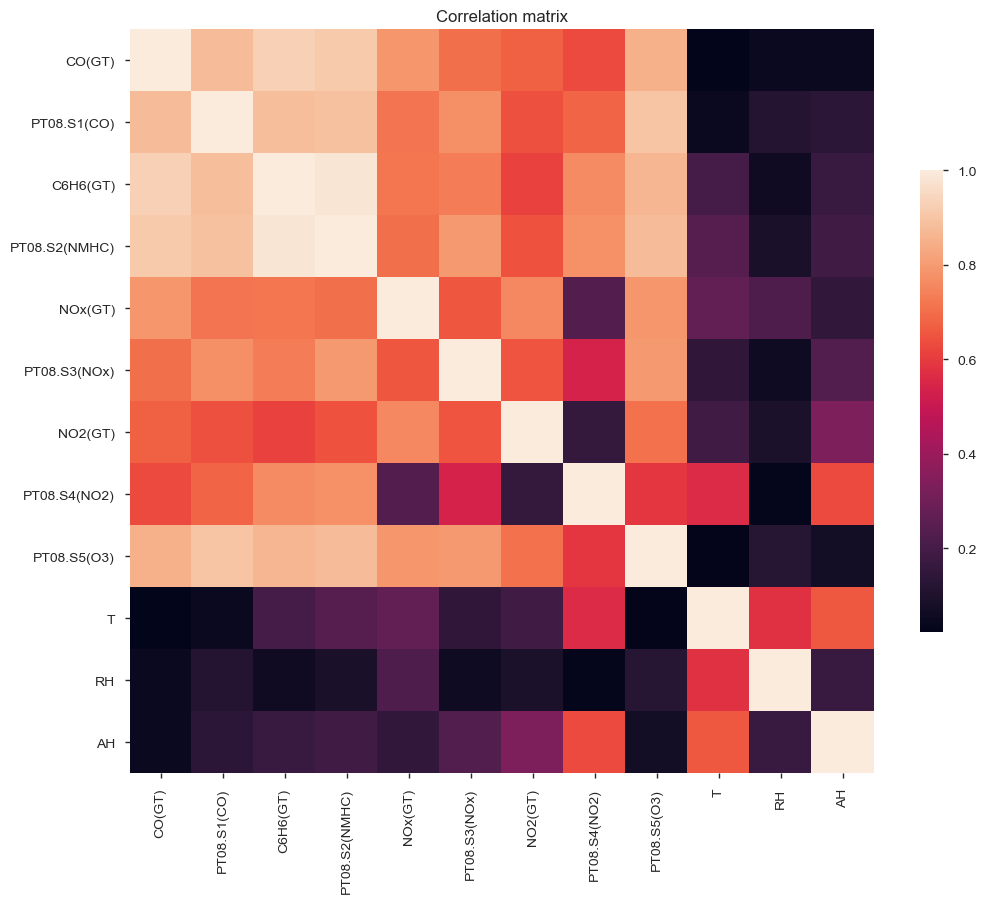

In [194]:
plt.figure(figsize=(12, 12))
corr = np.abs(AirQuality_NaNfix.corr())
ax = sns.heatmap(corr,  square=True, cbar_kws={"shrink": .5})  #center=0,
plt.title("Correlation matrix");

Между признаками CO(GT), PT08.S1(CO), C6H6(GT), PT08.S2(NMHC) и PT08.S5(O3) наблюдается довольно сильная связь. Так как большинство (если не все) из представленного в таблице - загрязнения (оксиды металлов, бензол и что-то еще), то скорее всего они могут вызваны одними и теми же причинами и их процент содержания, может увеличиваться в одни и те же промежутки времени. Например, утром вечером в будние дни люди едут на работу и с нее, выхлопы от машин вызывают резкое загрязнение воздух разными вредными веществами.

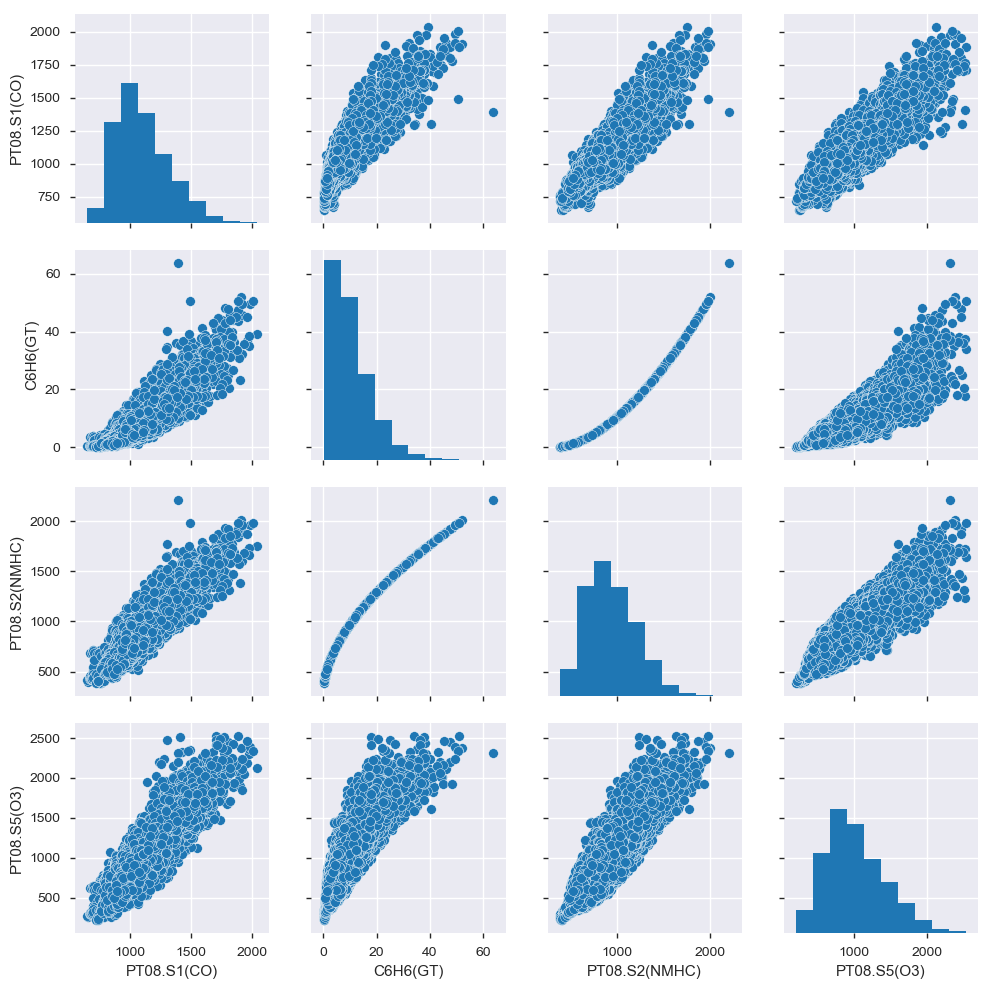

In [195]:
sns_plot = sns.pairplot(AirQuality_NaNfix[["PT08.S1(CO)", "C6H6(GT)","PT08.S2(NMHC)", "PT08.S5(O3)"]])

На диаграммах рассеяния явно выделяется одно значение обособленное от всех(выброс), я его удалил. Так же наблюдается либо логарифмическая, либо квадратичная зависимость между признаком PT08.S2 и таргетом C6H6.

In [196]:
AirQuality_NaNfix = AirQuality_NaNfix[AirQuality_NaNfix["C6H6(GT)"] < 60]

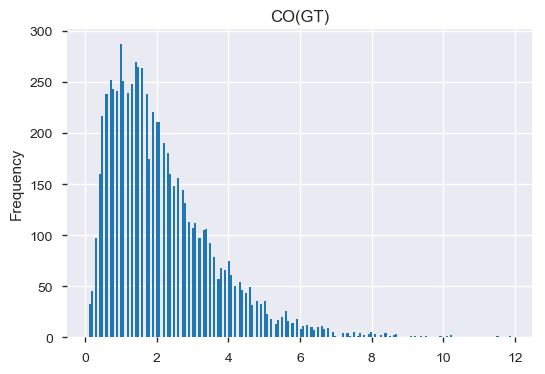

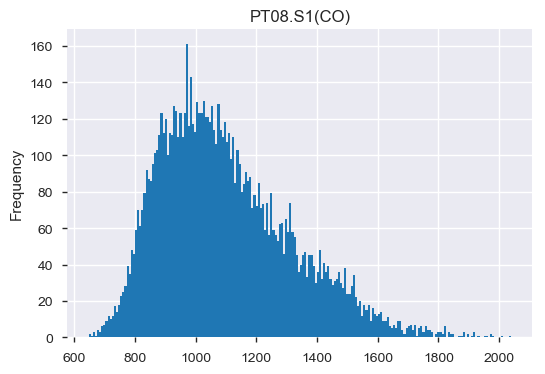

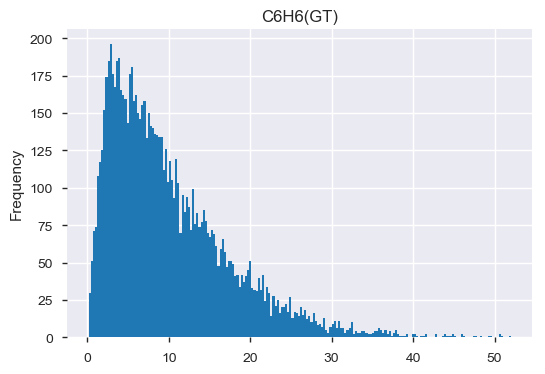

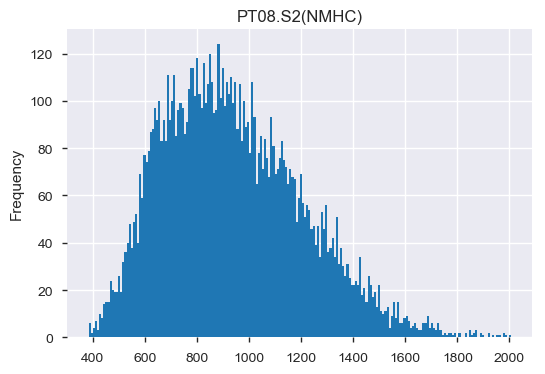

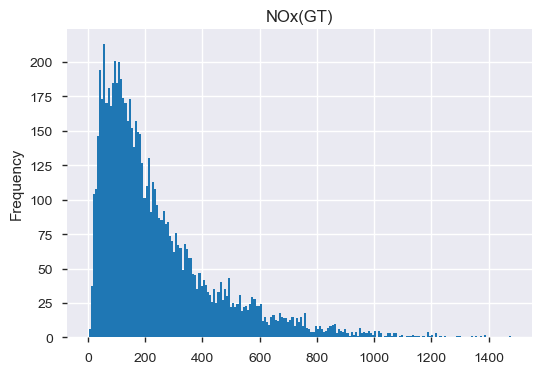

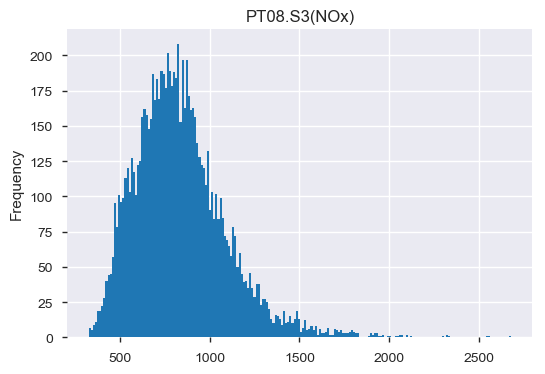

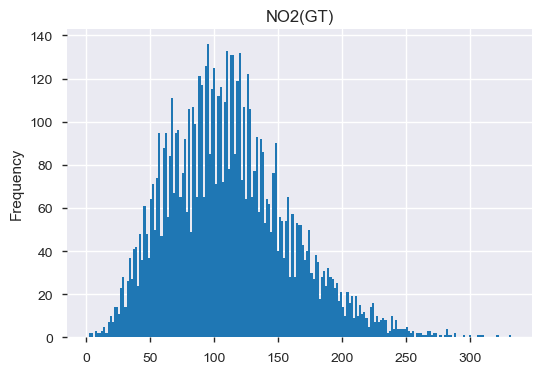

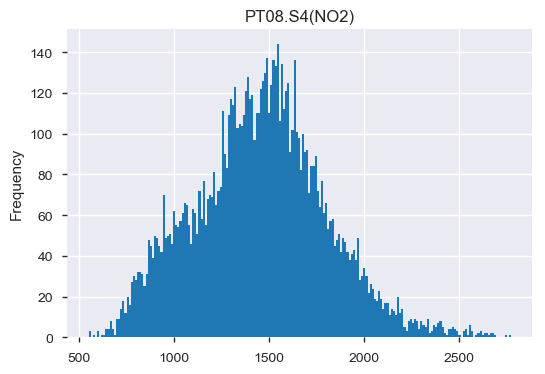

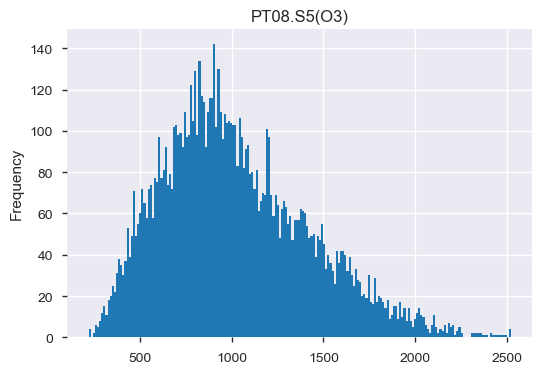

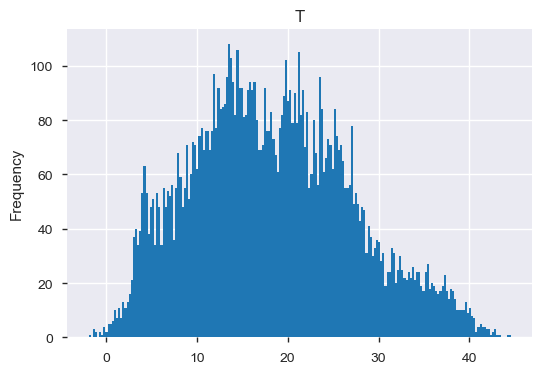

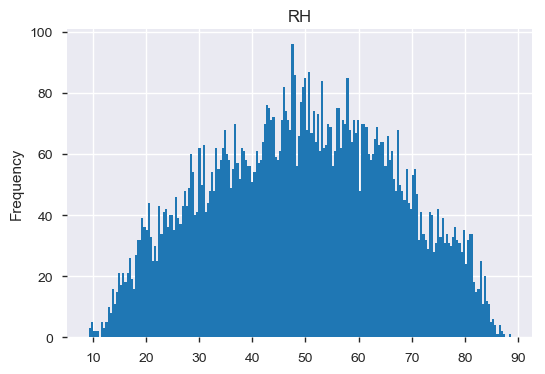

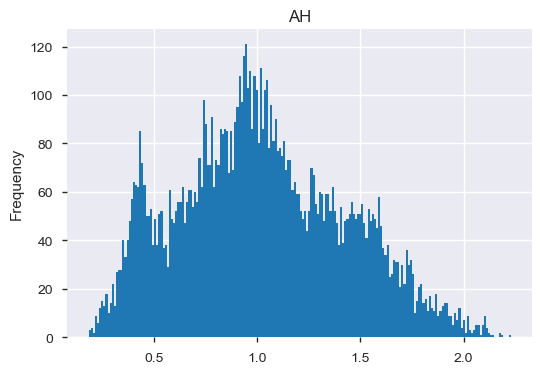

In [197]:
for i in list(AirQuality_NaNfix.columns)[2:]:
    
    plt.figure()  
    plt.title(i)
    AirQuality_NaNfix[i].plot.hist( bins=200, figsize=(6, 4))
    plt.show()

У некоторых признаков и у таргета наблюдается выраженная левая ассиметрия. Ниже произведено логарифмирование признаков, коэффициент ассиметрии которых больше 0.5.

In [198]:
numeric_feats=AirQuality_NaNfix.dtypes[AirQuality_NaNfix.dtypes=="float64"].index
num_df=AirQuality_NaNfix[numeric_feats]

skewed_feats = num_df.apply(lambda x: skew(x)) 

skewed_feats = skewed_feats[skewed_feats > 0.5]
skewed_feats = skewed_feats.index

AirQuality_NaNfix["log_"+skewed_feats] = np.log1p(num_df[skewed_feats])

In [199]:
AirQuality_NaNfix=AirQuality_NaNfix.fillna(AirQuality_NaNfix.median())

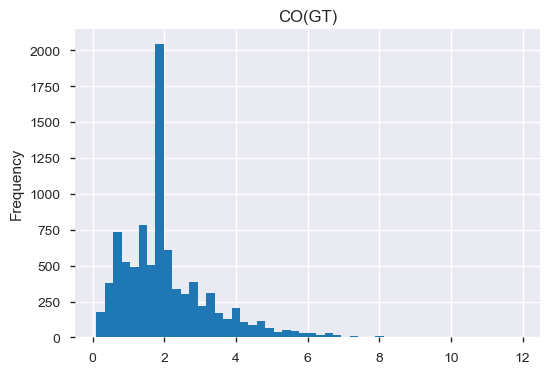

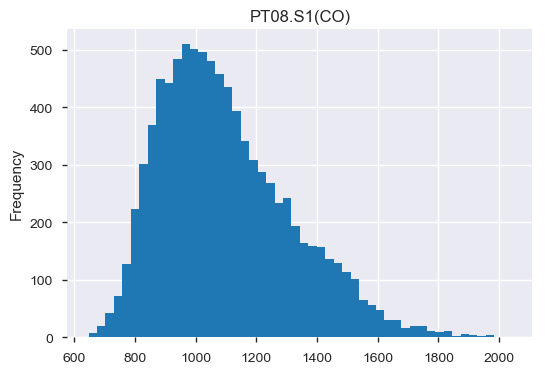

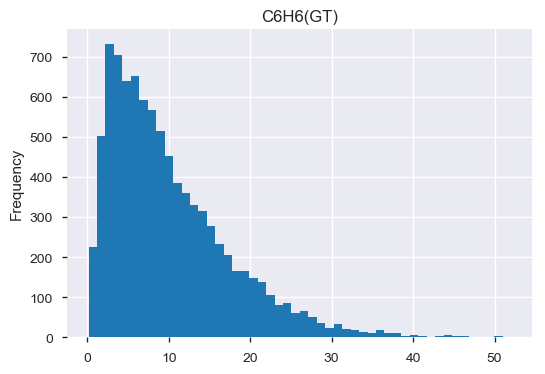

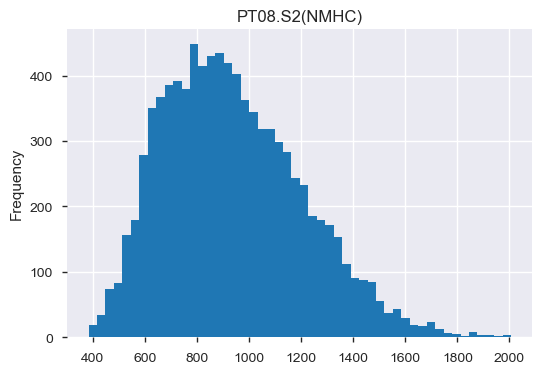

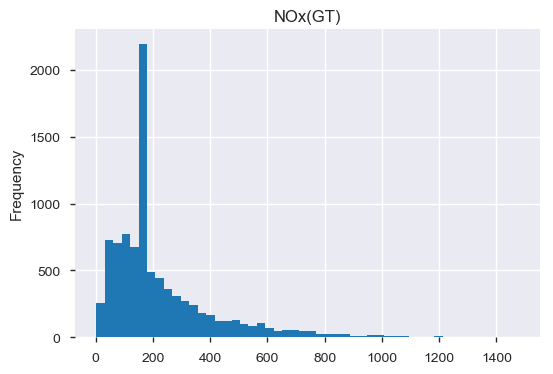

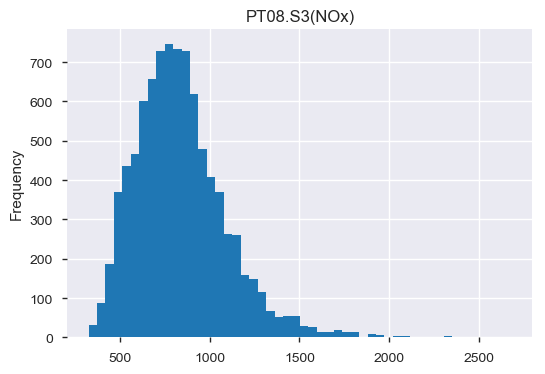

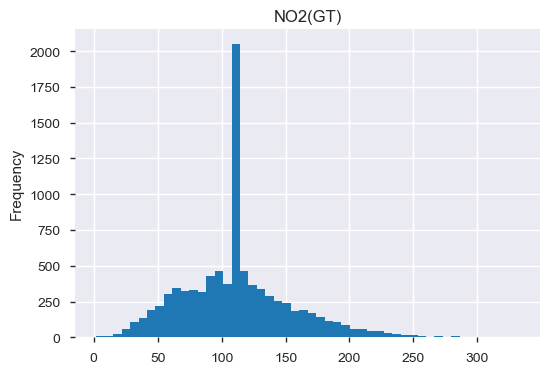

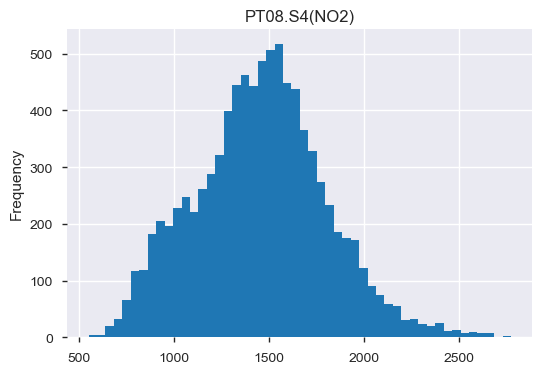

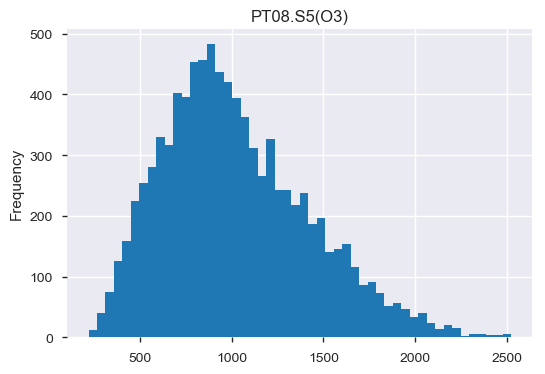

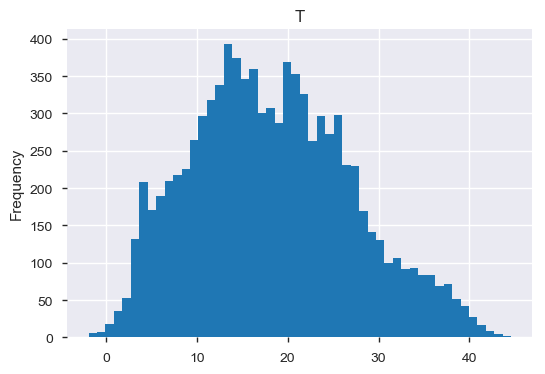

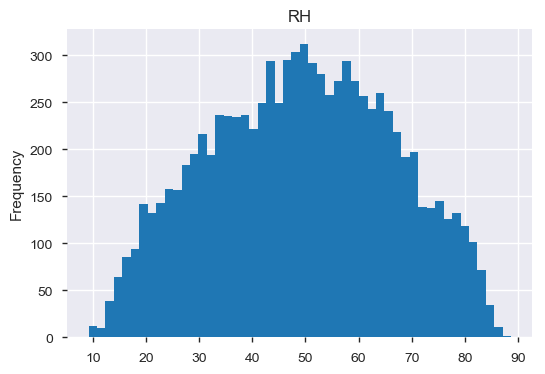

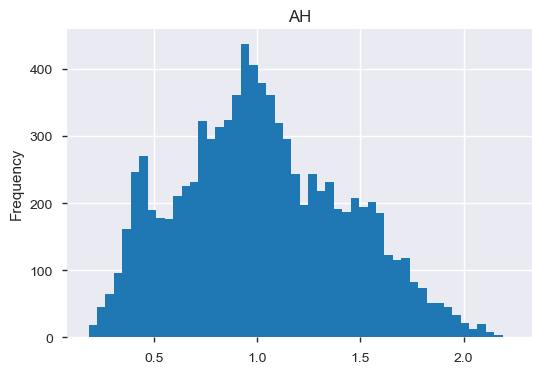

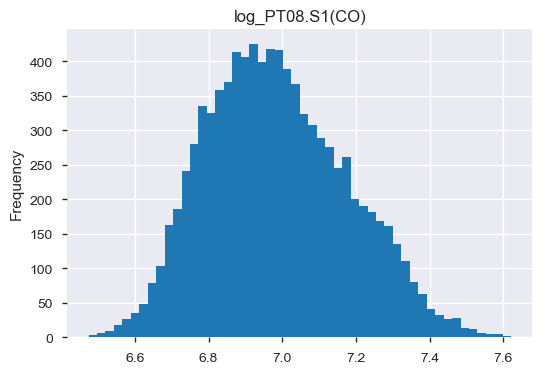

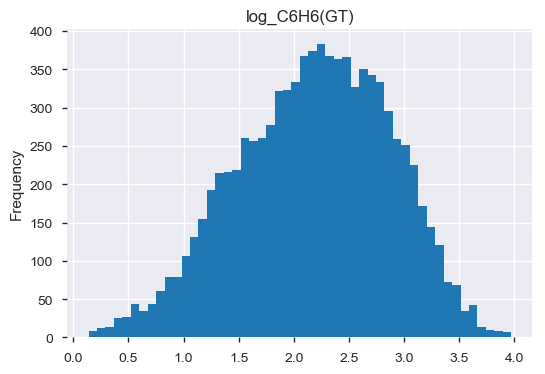

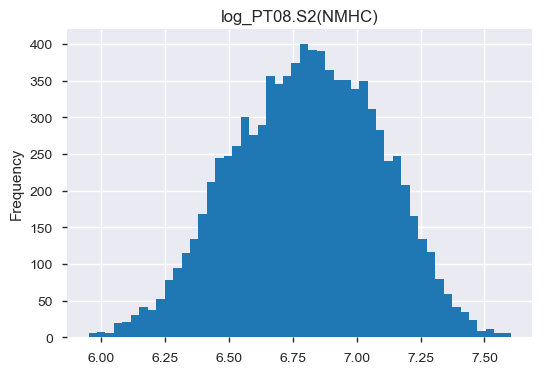

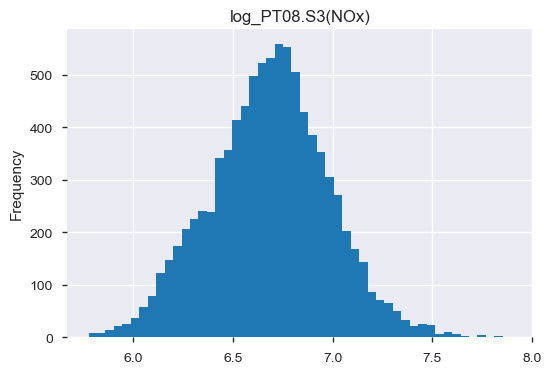

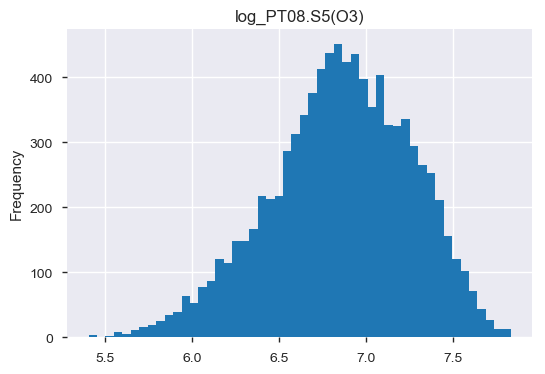

In [200]:
for i in list(AirQuality_NaNfix.columns)[2:]:
    plt.figure()  
    plt.title(i)
    AirQuality_NaNfix[i].plot.hist( bins=50, figsize=(6, 4))
    plt.show()

### Обработка даты и времени

Ниже сделан перевод выражения из типа Time(категориального) в обычный числовой тип, значение которого равно часам в которые были произведены замеры, чтобы можно было строить от него зависимость, как от непрерывной велечины.

Так же были введены три числовых столбца, таких как год, месяц и число, и три категориальных стобца, которые указывают в какой день недели было произведено измерение. Я решил поделить дни недели на группы с понедельника по четверг(рабочие дни), пятницу(предвыходной день) и с субботы по воскресенью(выходные дни), потому что дни в данных группах не имеют между собой различий.

In [201]:
def get_hour(time):
    return int(str(time)[0:2])
def get_year(date):
    return date.year
def get_month(date):
    return date.month
def get_day(date):
    return date.day
def get_workday(date):
    return int(((date.weekday()>(-1)) and (date.weekday() < 4)))
def get_friday(date):
    return int((date.weekday()==4))
def get_weekend(date):
    return int(((date.weekday()>(4)) and (date.weekday() < 7)))

AirQuality_NaNfix['TimeHour'] = AirQuality_NaNfix['Time'].apply(get_hour)
AirQuality_NaNfix['Year'] = AirQuality_NaNfix['Date'].apply(get_year)
AirQuality_NaNfix['Month'] = AirQuality_NaNfix['Date'].apply(get_month)
AirQuality_NaNfix['Day'] = AirQuality_NaNfix['Date'].apply(get_day)
AirQuality_NaNfix['WorkDay'] = AirQuality_NaNfix['Date'].apply(get_workday)
AirQuality_NaNfix['Friday'] = AirQuality_NaNfix['Date'].apply(get_friday)
AirQuality_NaNfix['Weekend'] = AirQuality_NaNfix['Date'].apply(get_weekend)

In [202]:
AirQuality_NaNfix.describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),"8,990.00",2.07,1.30,0.10,1.20,1.80,2.60,11.90
PT08.S1(CO),"8,990.00","1,099.68",217.07,647.25,936.75,"1,062.88","1,231.12","2,039.75"
C6H6(GT),"8,990.00",10.08,7.43,0.15,4.44,8.24,13.99,52.05
PT08.S2(NMHC),"8,990.00",938.89,266.50,383.25,734.31,909.00,"1,116.25","2,006.75"
NOx(GT),"8,990.00",230.73,188.62,2.00,112.00,178.00,280.00,"1,479.00"
PT08.S3(NOx),"8,990.00",835.42,256.79,322.00,658.00,805.50,969.38,"2,682.75"
NO2(GT),"8,990.00",111.47,43.19,2.00,85.00,108.50,132.00,332.60
PT08.S4(NO2),"8,990.00","1,456.12",346.22,551.00,"1,226.56","1,462.75","1,673.50","2,775.00"
PT08.S5(O3),"8,990.00","1,022.64",398.27,221.00,731.31,963.25,"1,273.25","2,522.75"
T,"8,990.00",18.32,8.83,-1.90,11.80,17.75,24.40,44.60


### Первичная линейная регрессия

Проведем линейную регресию нелогарифмированного таргета C6H6 от нелогарифмированных признаков, а затем с логарифмированными таргетом и признакоми и сравним результаты.

In [203]:
target=AirQuality_NaNfix['C6H6(GT)']
data=AirQuality_NaNfix.drop('C6H6(GT)', axis=1).iloc[:,2:10]
log_target=AirQuality_NaNfix['log_C6H6(GT)']
log_data=AirQuality_NaNfix.drop('log_C6H6(GT)', axis=1).iloc[:,14:18]

In [204]:
def split(data, target):
    separating_index=math.ceil(data.shape[0]*0.7)

    train_feats=data[:separating_index]
    train_target=target[:separating_index]
    test_feats=data[separating_index:]
    test_target=target[separating_index:]
    
    return train_feats, train_target, test_feats, test_target

In [205]:
train_feats, train_target, test_feats, test_target=split(data, target)

In [206]:
linreg=LinearRegression()
linreg.fit(train_feats, train_target);

In [207]:
def show_metrics_and_coefs(test_target, test_feats, linreg):
    metrics=pd.DataFrame({'r2_score':[r2_score(test_target,linreg.predict(test_feats))],
                     'neg_mean_squared_error':[(-1)*mean_squared_error(test_target,linreg.predict(test_feats))],
                     'neg_median_absolute_error':[(-1)*median_absolute_error(test_target,linreg.predict(test_feats))]},
                    index=['value']
                   )
    coef_table=pd.DataFrame({'Feature':test_feats.columns.values.tolist(), 'Coefficient':linreg.coef_.tolist()})
    display(metrics.T)
    display(coef_table.T)

In [208]:
show_metrics_and_coefs(test_target, test_feats, linreg)

,value
neg_mean_squared_error,-4.16
neg_median_absolute_error,-1.51
r2_score,0.90


,0,1,2,3,4,5,6,7
Coefficient,0.21,-0.00,0.03,0.00,0.00,-0.01,0.00,0.00
Feature,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)


In [209]:
train_logfeats, train_logtarget, test_logfeats, test_logtarget=split(log_data, log_target)
log_linreg=LinearRegression()
log_linreg.fit(train_logfeats, train_logtarget);
show_metrics_and_coefs(test_logtarget, test_logfeats, log_linreg)

,value
neg_mean_squared_error,-0.00
neg_median_absolute_error,-0.02
r2_score,1.00


,0,1,2,3
Coefficient,-0.07,2.45,0.01,0.01
Feature,log_PT08.S1(CO),log_PT08.S2(NMHC),log_PT08.S3(NOx),log_PT08.S5(O3)


Модель с использованием логарифмов показала результат лучше, чем без использования логарифмов. Так же в модели без использования логарифмов(да и с ними тоже), признак PT08.S2(NMHC) имеет относительно большой коэффициент(если сравнивать признаки по отношению mean/coef), что говорит, что целевая переменная имеет сильную связь с ним, попробуем возвести в квадрат PT08.S2(NMHC).

In [210]:
AirQuality_NaNfix['PT08.S2(NMHC)_sq'] = AirQuality_NaNfix['PT08.S2(NMHC)']**2

In [211]:
target=AirQuality_NaNfix['C6H6(GT)']
data=AirQuality_NaNfix.drop('C6H6(GT)', axis=1).iloc[:,24:26]

In [212]:
train_feats, train_target, test_feats, test_target=split(data, target)
linreg=LinearRegression()
linreg.fit(train_feats, train_target);
show_metrics_and_coefs(test_target, test_feats, linreg)
linreg.coef_.tolist()

,value
neg_mean_squared_error,-0.04
neg_median_absolute_error,-0.09
r2_score,1.00


,0,1
Coefficient,-0.03,0.00
Feature,Weekend,PT08.S2(NMHC)_sq


[-0.030674252486025767, 1.3591294619362582e-05]

Данная модель очень хорошо предсказывает значения C6H6. Что является плюсом в сторону связи между квадратом PT08.S2 и C6H6. Хотя абсолютная медианная и среднеквадратичные ошибки немного увеличись, скорее всего зависимость целевой переменной от PT08.S2 - логарифмическая, а не квадратичная.
(в модели присутствуют два признака, потому что еще решается проблема с тем, что fit не хочет проглатывать одномерный массив)

## Стандартизация
Проведем стандартизацию признаков, чтобы уменьшить влияние ошибок

In [213]:
data = AirQuality_NaNfix.drop(['TimeHour', 'Year', 'Month', 'Day','WorkDay','Friday','Weekend','Date', 'Time','C6H6(GT)','PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S5(O3)','PT08.S2(NMHC)_sq', 'log_C6H6(GT)'], axis = 1).copy()

train, test, train_logtarget, test_logtarget=train_test_split(data, log_target, test_size=0.3, shuffle = False)

scaler = StandardScaler()

train_scaled=train.copy()
test_scaled=test.copy()

scaled_columns = ['CO(GT)','NOx(GT)','NO2(GT)','PT08.S4(NO2)','T','RH','AH','log_PT08.S1(CO)','log_PT08.S2(NMHC)','log_PT08.S3(NOx)','log_PT08.S5(O3)']

train_scaled[scaled_columns]=scaler.fit_transform(train[scaled_columns])
test_scaled[scaled_columns]=scaler.transform(test[scaled_columns])

In [214]:
log_linreg=LinearRegression()
log_linreg.fit(fix_train_scaled, train_logtarget);
show_metrics_and_coefs(test_logtarget, fix_test_scaled, log_linreg)

,value
neg_mean_squared_error,-0.00
neg_median_absolute_error,-0.01
r2_score,1.00


,0,1,2,3,4,5,6,7,8,9,10
Coefficient,-0.00,-0.02,0.00,-0.03,0.00,0.00,0.01,0.00,0.71,0.01,0.00
Feature,CO(GT),NOx(GT),NO2(GT),PT08.S4(NO2),T,RH,AH,log_PT08.S1(CO),log_PT08.S2(NMHC),log_PT08.S3(NOx),log_PT08.S5(O3)


Модель построенная по стандартизированным признакам очень хорошо предсказывает значения целевой переменной C6H6. Почти не допуская ошибок.

## Анализ остатков
Проверим остатки последней модели на нормальность.

In [215]:
residuals = test_logtarget - log_linreg.predict(fix_test_scaled)
display(shapiro(residuals))

(0.9564170837402344, 1.0971969930100612e-27)

Остатки имеют нормальное распределение.

## LASSO-регуляризация
Проведем Lasso регуляризацию при тех же признаках, что и в предыдущей модели.

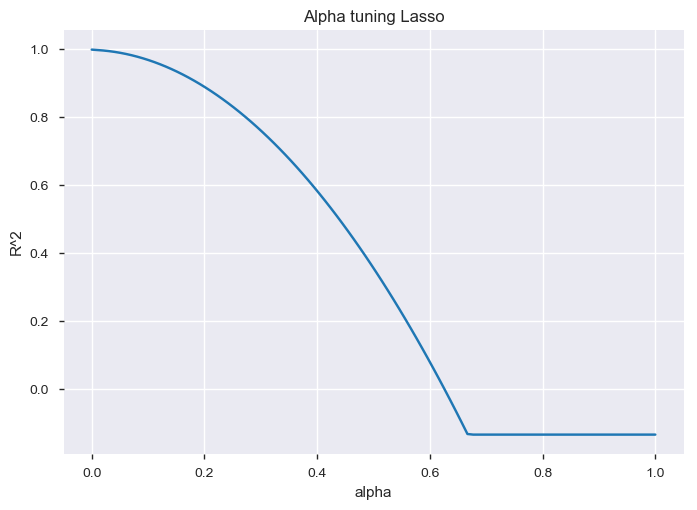

In [216]:
def r2(model,target,test):
    return(r2_score(target, model.predict(test)))

alphas = np.linspace(0, 1, 100)
cv_lasso = [r2(Lasso(alpha=alpha).fit(fix_train_scaled, train_logtarget),test_logtarget, fix_test_scaled) for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)

cv_lasso.plot(title = "Alpha tuning Lasso")
plt.xlabel("alpha")
plt.ylabel("R^2");

В нашем случае LASSO регуляризация не принесла хороших результатов. Начиная с определенного коэффициента alpha (примерно 0.65) модель имеет полностью зануленные коэффиценты и работает хуже константной. Но все же построим модель с LASSO-регуляризацией при сравнительно малом коэффициенте aplha

In [217]:
reg_Lasso=Lasso(alpha = 0.01)
reg_Lasso.fit(fix_train_scaled, train_logtarget)
show_metrics_and_coefs(test_logtarget, fix_test_scaled, reg_Lasso)
display(reg_Lasso.coef_)

,value
neg_mean_squared_error,-0.00
neg_median_absolute_error,-0.02
r2_score,1.00


,0,1,2,3,4,5,6,7,8,9,10
Coefficient,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.66,-0.00,0.00
Feature,CO(GT),NOx(GT),NO2(GT),PT08.S4(NO2),T,RH,AH,log_PT08.S1(CO),log_PT08.S2(NMHC),log_PT08.S3(NOx),log_PT08.S5(O3)


array([ 0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.65720434, -0.        ,  0.        ])

При регуляризации занулились все коэффициенты кроме коэффициента при log_PT08.S2, что доказывает, что он вносит наибольший вклад в целевую переменную.

## Кроссвалидация
Проведем кроссвалидацию модели построенной на признаках: CO(GT), NOx(GT), NO2(GT), PT08.S4(NO2), T, RH, AH, log_PT08.S1(CO), log_PT08.S2(NMHC), log_PT08.S3(NOx), log_PT08.S5(O3).

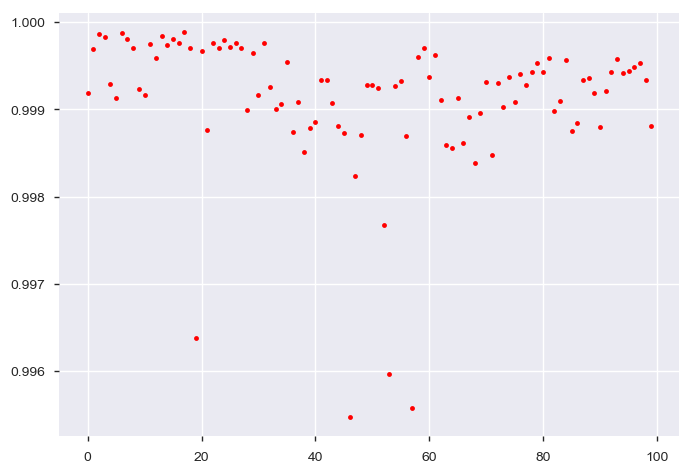

In [218]:
splits=100

tscv = TimeSeriesSplit(n_splits=splits)
plt.plot(range(0,splits),cross_val_score(LinearRegression(), data, log_target, cv=tscv), 'r.')

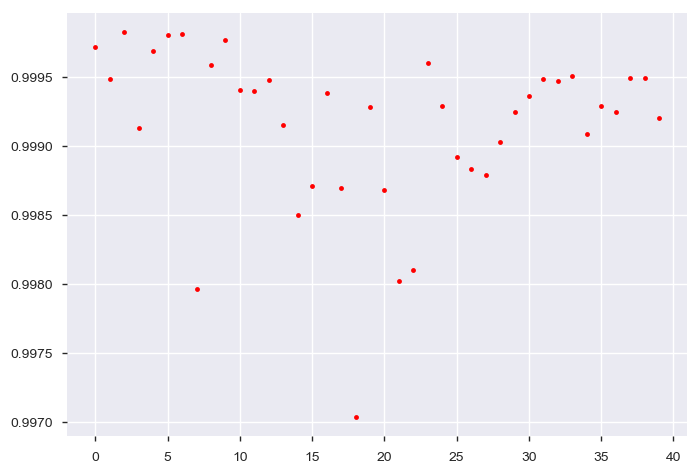

In [219]:
splits=40

tscv = TimeSeriesSplit(n_splits=splits)
plt.plot(range(0,splits),cross_val_score(LinearRegression(), data, log_target, cv=tscv), 'r.')

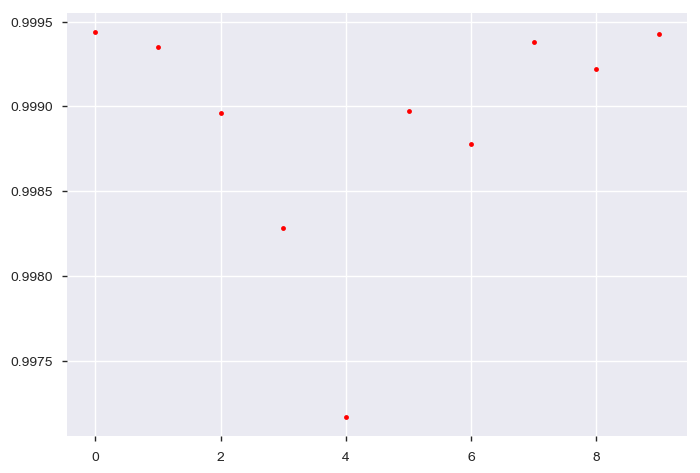

In [220]:
splits=10

tscv = TimeSeriesSplit(n_splits=splits)
plt.plot(range(0,splits),cross_val_score(LinearRegression(), data, log_target, cv=tscv), 'r.')

Значение R^2 при разных размерах сплитов не падало ниже 0.995, что говорит о том, что признаки выбраны хорошо и модель не переобучается и при этом достаточно хорошо предсказывает значения целевой переменной

## Полиномиальная регрессия
Построим линейную модель от признаков, которые достаточно легко измерить (время, дни недели, сезон, температура, влажность),  так как данные параметры почти не требуют затрат на свое измеренение. Время взято в 4-ой степени, так как в экселе наблюдалось увеличение значения C6H6 к 10 и 20 часам, при этом небольшое падение около 15 часов. То есть наблюдалось три экстремума.

In [221]:
easily_measurablу_feats = AirQuality_NaNfix[['T', 'RH', 'AH', 'WorkDay', 'Friday', 'Weekend']]

In [222]:
easily_measurablу_feats['TimeHour_deg4'] = AirQuality_NaNfix['TimeHour']**4
easily_measurablу_feats['TimeHour_deg3'] = AirQuality_NaNfix['TimeHour']**3
easily_measurablу_feats['TimeHour_deg2'] = AirQuality_NaNfix['TimeHour']**2
easily_measurablу_feats['TimeHour_deg1'] = AirQuality_NaNfix['TimeHour']

def get_winter(month):
    return int(((month>(0)) and (month < 3)) or (month == 12))
def get_autumn(month):
    return int((month>(2)) and (month < 6))
def get_summer(month):
    return int((month>(5)) and (month < 9))
def get_spring(month):
    return int((month>(8)) and (month < 12))

easily_measurablу_feats['Winter'] = AirQuality_NaNfix['Month'].apply(get_winter)
easily_measurablу_feats['Autumn'] = AirQuality_NaNfix['Month'].apply(get_autumn)
easily_measurablу_feats['Summer'] = AirQuality_NaNfix['Month'].apply(get_summer)
easily_measurablу_feats['Spring'] = AirQuality_NaNfix['Month'].apply(get_spring)

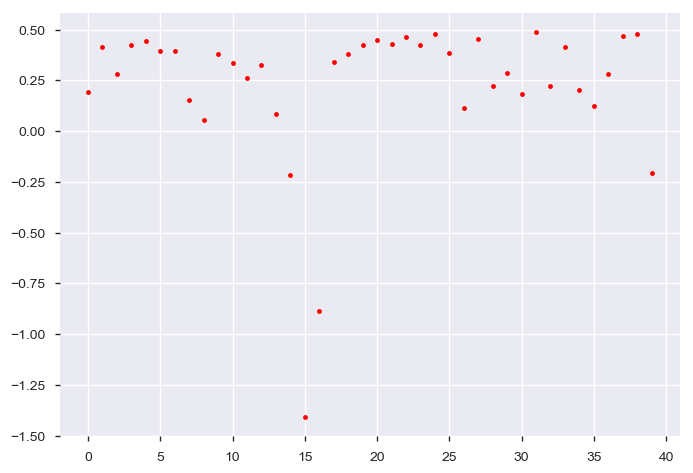

In [223]:
splits=40

tscv = TimeSeriesSplit(n_splits=splits)
plt.plot(range(0,splits),cross_val_score(LinearRegression(), easily_measurablу_feats, log_target, cv=tscv), 'r.')

Получившаяся модель указывает на недообучение, данных признаков не хватает для того, чтобы хорошо предсказывать значение C6H6. R^2 очень мал, в некоторых случаях он падает близко к 0 или даже уходит в отрицательную область, что говорит о том, что данная модель в среднем немногим лучше константной модели.